<a href="https://colab.research.google.com/github/yanncoadou/MLtutorials/blob/main/ML_IDPASC2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDPASC 2021 Machine learning hands-on**

# **Installation checks**

## XGBoost

In [ ]:
# preinstalled version 0.9.0 20210824
!pip install xgboost --upgrade # install 1.4.2 20210824
import xgboost as xgb
print(xgb.__version__)

     |████████████████████████████████| 166.7 MB 13 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
1.4.2


## LightGBM

In [ ]:
# preinstalled version 2.2.3 20210824
!pip install lightgbm --upgrade # install 3.2.1 20210824
import lightgbm as lgb
print (lgb.__version__)

     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
3.2.1


## tensorflow if not on Colab

In [ ]:
try:
  import tensorflow as tf
except ImportError as e:
  !pip install tensorflow
  import tensorflow as tf
print (tf.__version__)  # preinstalled version 2.6.0 20210824

2.6.0


## Enabling and testing the GPU
(largely copied from https://colab.research.google.com/notebooks/gpu.ipynb)

On COLAB only, you'll need to enable GPUs for the notebook:
- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Note the warning when activating GPU: *To get the most out of Colab, avoid using a GPU unless you need one.*

In [ ]:
COLAB=True # if running in COLAB
#COLAB=False # if not running on COLAB
GPU=True # if using GPU (can be True on COLAB and possibly Linux)
#GPU=False # no GPU on Mac and possibly Linux

In [ ]:
if COLAB: 
    # Display available and used memory.
    !free -h
    print("-"*70)
    # Display the CPU specification.
    !lscpu
    print("-"*70)
    # Display the GPU specification (if available).
    !(nvidia-smi | grep -q "has failed") && echo "No GPU found!" || nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:            12G        544M        9.9G        1.2M        2.2G         11G
Swap:            0B          0B          0B
----------------------------------------------------------------------
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse3

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  if GPU:
        raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
if GPU:
    gpu()

# Run the op several times.
from datetime import datetime
print (datetime.now())
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

2021-08-25 16:30:03.570296
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6294350699999995
GPU (s):
0.04369697099997438
GPU speedup over CPU: 83x


## Input dataset

In [ ]:
import os
if not os.path.isfile("dataWW_d1_600k.csv.gz"):
  try:
    import gdown
  except ImportError as e:
    !pip install gdown
    import gdown
  !gdown https://drive.google.com/uc?id=1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4
!ls -lrt

Downloading...
From: https://drive.google.com/uc?id=1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4
To: /content/dataWW_d1_600k.csv.gz
35.9MB [00:00, 63.6MB/s]
total 35072
drwxr-xr-x 1 root root     4096 Aug 13 13:35 sample_data
-rw-r--r-- 1 root root 35905611 Aug 25 13:39 dataWW_d1_600k.csv.gz


# Features correlation matrix

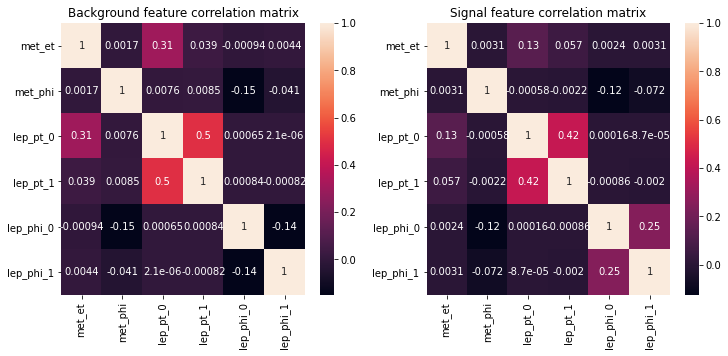

In [ ]:
import seaborn as sn # seaborn for nice plot quicker
fig,ax=plt.subplots(1, 2, figsize=(12, 5))

corrMatrix = data[target==0].corr()
ax[0].set_title("Background features correlation matrix")
sn.heatmap(corrMatrix, ax=ax[0], annot=True)

corrMatrix = data[target==1].corr()
ax[1].set_title("Signal features correlation matrix")
sn.heatmap(corrMatrix, ax=ax[1], annot=True)


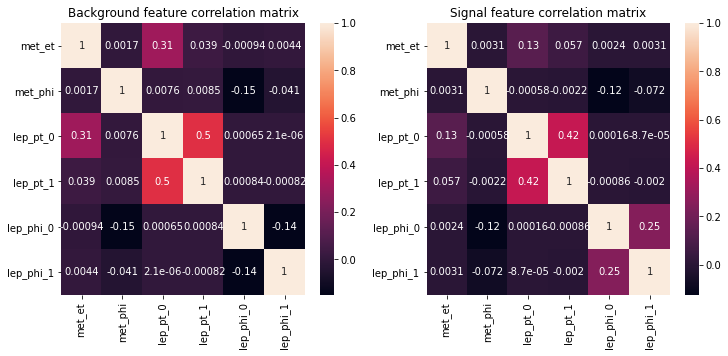

In [ ]:
import seaborn as sn # seaborn for nice plot quicker
fig,ax=plt.subplots(1, 2, figsize=(12, 5))

corrMatrix = data[target==0].corr()
ax[0].set_title("Background feature correlation matrix")
sn.heatmap(corrMatrix, ax=ax[0], annot=True)

corrMatrix = data[target==1].corr()
ax[1].set_title("Signal feature correlation matrix")
sn.heatmap(corrMatrix, ax=ax[1], annot=True)


# Feature importance
Feature importance allows to display the importance of each feature without rerunnning the training. It is obtained from internal algorithm quantities, like number of time a feature is used to definea leaf. Magnitude is arbitrary. It can be used as a not very reliable indication of which feature is the most discriminant.

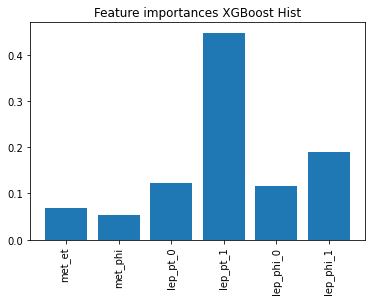

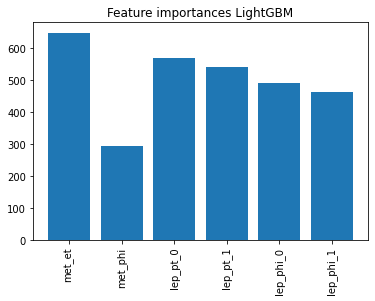

In [ ]:
plt.bar(data.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")
#plt.savefig(new_dir + "/VarImp_BDT_XGBoost_Hist.pdf",bbox_inches='tight')
plt.show()
plt.bar(data.columns.values, gbm.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances LightGBM")
#plt.savefig(new_dir + "/VarImp_BDT_LightGBM.pdf",bbox_inches='tight')
plt.show()


# Permutation importance

A better way to show the importance of each feature is Permutation Importance, where each feature in turn is replaced by an instance of an other event (effectively switching it off by randomising).

However, report can be misleading in case of highly correlated variables.

Available in [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html]) but without event weights in Colab version (0.22).
   


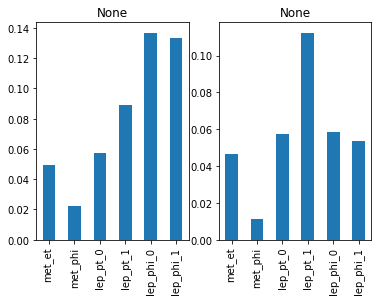

In [ ]:
if True:
  from sklearn.inspection import permutation_importance
  result_xgb = permutation_importance(xgb, X_test, y_test, n_repeats=1, random_state=42, n_jobs=2)
  forest_importances_xgb = pd.Series(result_xgb.importances_mean, index=list(data.columns.values))

  result_gbm = permutation_importance(gbm, X_test, y_test, n_repeats=1, random_state=42, n_jobs=2)
  forest_importances_gbm = pd.Series(result_gbm.importances_mean, index=list(data.columns.values))

  fig, ax = plt.subplots(1,2)
  ax
  forest_importances_xgb.plot.bar(ax = ax[0], subplots=True)
  forest_importances_gbm.plot.bar(ax = ax[1], subplots=True)


Another implementation targetting HEP:

https://github.com/aghoshpub/permutationImportancePhysics 

In particular it allows to : 
   * use event weights
   * display directly the loss in whatever criterion (ROC auc, asimov significance) when the feature is switched off
   * display the feature importance for a specific subset (for example the most signal like)
   * it can even display which feature has the largest impact on systematics


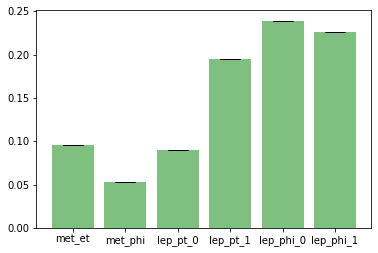

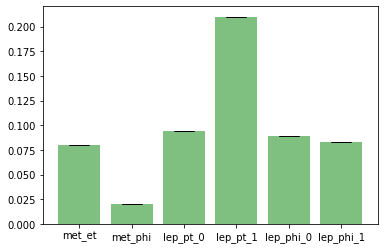

In [ ]:
if True:
    !pip install PermutationImportancePhysics
    from permutationimportancephysics.PermutationImportance import PermulationImportance # note the delibrate typo PermuLation
    PI_xgb = PermulationImportance(model=xgb, X=X_test,y=y_test,weights=weights_test,\
                           n_iterations=1,usePredict_poba=True, scoreFunction="amsasimov", colNames=list(data.columns.values))
    #PI_xgb.dislayResults()
    plott_xgb = PI_xgb.plotBars()
    plott_xgb.show()
    PI_gbm = PermulationImportance(model=gbm, X=X_test,y=y_test,weights=weights_test,\
                           n_iterations=1,usePredict_poba=True, scoreFunction="amsasimov", colNames=list(data.columns.values))
    #PI_gbm.dislayResults()
    plott_gbm = PI_gbm.plotBars()
    plott_gbm.show()
